In [1]:
from IPython.display import Image
from IPython.display import HTML
import json
import quandl
import yfinance as yf
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="show"></form>''')

# WASDE Event Analysis on Hisorical Realized Volatility in Agricultural Products ###

### Background

-Every month, the USDA realses the "World Agricultural Supply and Demand Estimates" (WAS-DEE) that provides a comprehensive forecast of the supply and demand for major crops. 

-Featured in the 1983 movie Trading Places, WASDE is released monthly and has a significant influence on the price of agricultural products

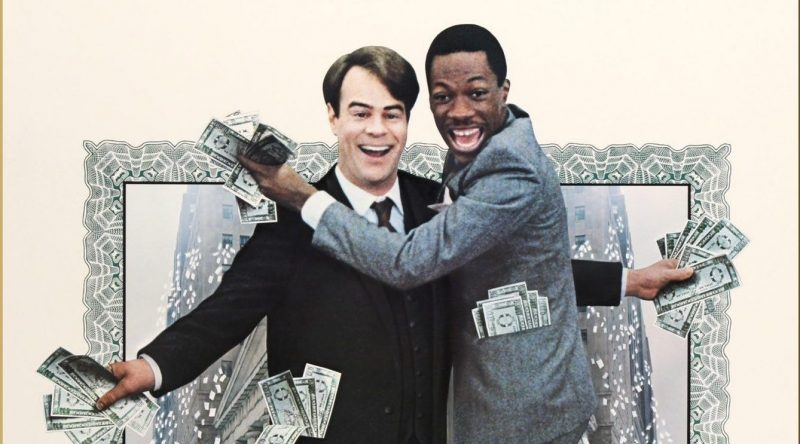

In [3]:
display(Image('https://worldgeeklynews.com/wp-content/uploads/2018/12/trading_places_1983_30x40_original_film_art_f_2000x-e1543791005783.jpg', width=500, height=500))

-Valentine and Winthorpe (above) get ahold of the WASDE before release, and are able to trade their way into millions of dollars

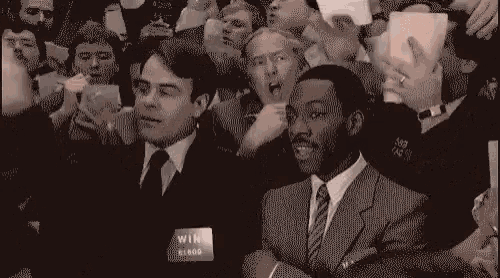

In [4]:
display(Image('https://media1.tenor.com/images/37c28fbc9fcf1f10cfb87cbacc64e0b6/tenor.gif', width=500, height=500))

-The reason they were able to make so much money is because the release of the report has a substantial effect on volatility. 

-Volatility is the main unknown variable in the equation that everyone uses to calculate the price of options.



### What is an Option? ###

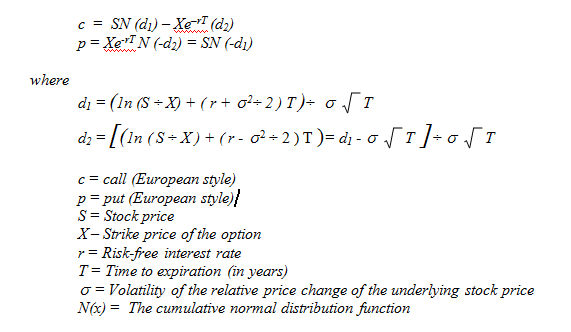

In [5]:
display(Image('https://steadyoptions.com/uploads/monthly_2018_02/image.png.432fa648588cb4e73b19a6dc019a78e1.png', width=500, height=500))

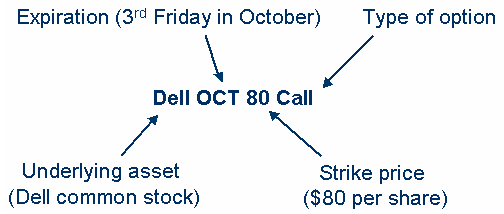

In [6]:
display(Image('https://financetrain.com/wp-content/uploads/2010/10/option_identify.png', width=500, height=500))

-All of these values are known to the world _except_ volatility

-As you might expect, grain prices and volatility are very seasonal. There is quite a bit of uncertainty in the summer momths as the crops are being harvested. There are risks of drought, flooding, and trade wars to just name a few

-Accordingly, WASDE reports in the summer have more crop information and one would expect them to have a bigger influence on prices. 

-We can use data analysis to quantify and predict the degree to which these reports are indeed seasonal


### Hypothesis ###

-WASDE is typically a significant price mover in the summer months and insignificant in the winter. It’s effect on realized volatility of agricultural futures should be sharply more pronounced in the the summer months (grain being harvested) than in the winter months (grain being planted or stored).

### Gathering Data ###

-Using Corn Futures (ticker = 'ZC') as our main test subject, we can bring in the closing prices from the last 10 years

In [7]:
corn = "ZC=F"
zc = yf.Ticker(corn)

In [8]:
zctot = zc.history(start=datetime(2010,1,1), end=datetime(2020,12,31)).drop(['Open','High', 'Low','Volume', 'Dividends','Stock Splits'],axis=1).reset_index()
zctot

Date   Close
0    2010-01-04  418.50
1    2010-01-05  418.75
2    2010-01-06  421.75
3    2010-01-07  417.50
4    2010-01-08  423.00
...         ...     ...
2598 2020-06-02  324.00
2599 2020-06-03  324.25
2600 2020-06-04  328.75
2601 2020-06-05  332.50
2602 2020-06-08  333.25

[2603 rows x 2 columns]

-Next, we read in an excel file with each calendar day a WASDE was released (usually 1 per month), and merge the 2 dataframes

In [9]:
event_days = pd.read_excel('wasde_dates.xlsx')

In [10]:
event_days['Is Event'] = 1

In [11]:
new_df = pd.merge(zctot, event_days, how='left', on='Date').fillna(0)
new_df

Date   Close  Is Event
0    2010-01-04  418.50       0.0
1    2010-01-05  418.75       0.0
2    2010-01-06  421.75       0.0
3    2010-01-07  417.50       0.0
4    2010-01-08  423.00       0.0
...         ...     ...       ...
2598 2020-06-02  324.00       0.0
2599 2020-06-03  324.25       0.0
2600 2020-06-04  328.75       0.0
2601 2020-06-05  332.50       0.0
2602 2020-06-08  333.25       0.0

[2603 rows x 3 columns]

In [12]:
new_df = new_df.set_index('Date')
new_df['Is Event'].value_counts(dropna=False)

0.0    2479
1.0     124
Name: Is Event, dtype: int64

-Add some change on day values

In [13]:
new_df['Change'] = new_df['Close'].diff(1)

In [14]:
new_df['Prior Close'] = new_df['Close'].shift(1)
new_df.head()

Close  Is Event  Change  Prior Close
Date                                             
2010-01-04  418.50       0.0     NaN          NaN
2010-01-05  418.75       0.0    0.25       418.50
2010-01-06  421.75       0.0    3.00       418.75
2010-01-07  417.50       0.0   -4.25       421.75
2010-01-08  423.00       0.0    5.50       417.50

-Now we need to calculate historical volatility

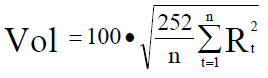

-Where:

Vol = Realized volatility

252 = a constant representing the approximate number of trading days in a year

t = a counter representing each trading day

n = number of trading days in the measurement time frame

Rt = continuously compounded daily returns as calculated by the formula:

Rt = ln(x/y)

x = closing price on day t

y = closing price on day t-1

-And add some Vol calculation columns

-Note: a Vol of 16 would indicate an expected daily move of 1% up or down 

In [15]:
new_df['One_D_Comp_Return'] = np.log(new_df['Close']/new_df['Prior Close'])

In [16]:
def one_day_vol(comp_ret):
    return np.sqrt((252/1)*(comp_ret**2))*100

In [17]:
new_df['One_D_Vol'] = new_df['One_D_Comp_Return'].apply(one_day_vol)

In [18]:
new_df.head()

Close  Is Event  Change  Prior Close  One_D_Comp_Return  \
Date                                                                   
2010-01-04  418.50       0.0     NaN          NaN                NaN   
2010-01-05  418.75       0.0    0.25       418.50           0.000597   
2010-01-06  421.75       0.0    3.00       418.75           0.007139   
2010-01-07  417.50       0.0   -4.25       421.75          -0.010128   
2010-01-08  423.00       0.0    5.50       417.50           0.013088   

            One_D_Vol  
Date                   
2010-01-04        NaN  
2010-01-05   0.948015  
2010-01-06  11.332237  
2010-01-07  16.077983  
2010-01-08  20.775976

-Now that we know the realized volatility on any given day, we need something to compare it to.

-We will take the average daily vol for that year, and simply subtract it from the 1D vol to arrive at an excess vol value.

-This represents how much more volatile corn prices were on a given day relative to the yearly average

In [19]:
new_df['Average Vol'] = new_df['One_D_Vol'].resample('Y').mean()

In [20]:
new_df['Yr Average Vol'] = new_df['Average Vol'].fillna(method='backfill',axis=0)

In [21]:
new_df['One_D_Excess_Vol'] = new_df['One_D_Vol'] - new_df['Yr Average Vol'] 

In [22]:
new_df = new_df.drop('Average Vol', axis=1)

In [23]:
new_df['Yr Average Vol'].resample('Y').mean()

Date
2010-12-31    23.895615
2011-12-31    21.868716
2012-12-31    21.868716
2013-12-31    20.701546
2014-12-31    18.293842
2015-12-31    17.665288
2016-12-31    13.876787
2017-12-31    13.876787
2018-12-31    13.876787
2019-12-31    17.394002
2020-12-31          NaN
Freq: A-DEC, Name: Yr Average Vol, dtype: float64

-Because we only care about volatility on event days, we'll create a new dataframe that only includes WASDE days

In [24]:
wasde_days = new_df[new_df['Is Event'] == 1].copy()

In [25]:
wasde_days = wasde_days.drop('Is Event', axis=1)

In [26]:
wasde_days.head()

Close  Change  Prior Close  One_D_Comp_Return   One_D_Vol  \
Date                                                                     
2010-01-12  392.50  -30.00       422.50          -0.073653  116.920369   
2010-02-09  358.50    2.50       356.00           0.006998   11.108868   
2010-03-10  355.50   -3.25       358.75          -0.009101   14.446624   
2010-04-09  345.75   -2.50       348.25          -0.007205   11.437015   
2010-05-11  369.75    6.75       363.00           0.018424   29.247618   

            Yr Average Vol  One_D_Excess_Vol  
Date                                          
2010-01-12       23.895615         93.024755  
2010-02-09       23.895615        -12.786747  
2010-03-10       23.895615         -9.448991  
2010-04-09       23.895615        -12.458600  
2010-05-11       23.895615          5.352003

## Seasonality Analysis ##

In [27]:
wasde_days['Month'] = wasde_days.index.month

In [28]:
wasde_days['Year'] = wasde_days.index.year

-At first look, it seems as though our hypothesis is correct

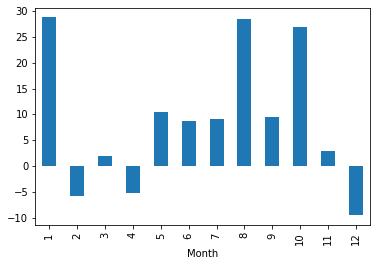

In [29]:
wasde_days['One_D_Excess_Vol'].groupby(wasde_days['Month']).mean().plot(kind='bar')

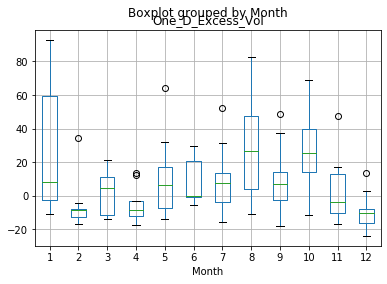

In [30]:
wasde_days.boxplot(column='One_D_Excess_Vol', by='Month')

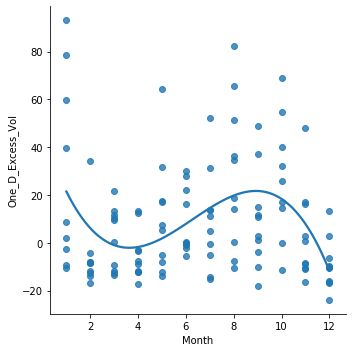

In [31]:
sns.lmplot(x='Month', y='One_D_Excess_Vol', data=wasde_days, ci=None, order=3)

-Summer months clearly show higher excess vol, with the exception of January.

-I initially thought that the very first data point in our set was skewing the data. It was easy to find and goes against our hypothesis, but when stripping out that year we see a similar trend:

In [32]:
no_2010_wasde_days = wasde_days['2011': '2019']

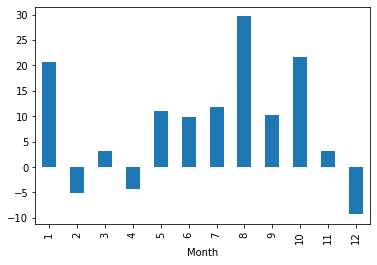

In [33]:
no_2010_wasde_days['One_D_Excess_Vol'].groupby(wasde_days['Month']).mean().plot(kind='bar')

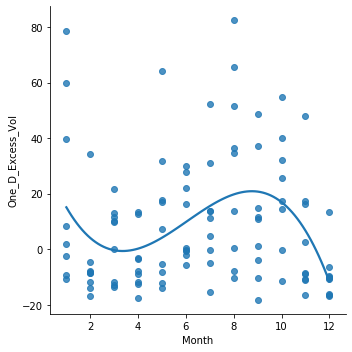

In [34]:
sns.lmplot(x='Month', y='One_D_Excess_Vol', data=no_2010_wasde_days, ci=None, order=3)

-So, we learned something big here. Winter WASDE's are typically much less volatile, except the Jan WASDE which his historical precendent to be particularly large

-We only have 124 data points total, so to help us go through this data further we can use filters

In [35]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


### Filter by Month ###

In [36]:
@interact
def show_month(column='Month', x=wasde_days['Month']):
    return wasde_days.loc[wasde_days['Month'] == x]

interactive(children=(Text(value='Month', description='column'), Dropdown(description='x', options=(1, 2, 3, 4…

### Filter by Excess Vol ###

In [37]:
@interact
def show_high_vol_wasde(column='One_D_Excess_Vol', x=100):
    return wasde_days.loc[wasde_days['One_D_Excess_Vol'] > x]

interactive(children=(Text(value='One_D_Excess_Vol', description='column'), IntSlider(value=100, description='…

### Holt Winters ###

In [38]:
train = wasde_days['2014':'2018']
test = wasde_days['2019']

C:\Users\stephen.kearns\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\stephen.kearns\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\stephen.kearns\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: overflow encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


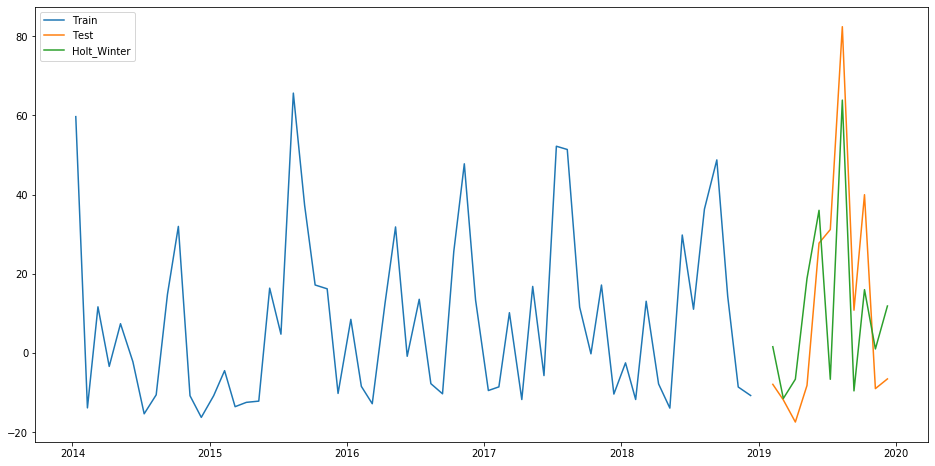

In [39]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['One_D_Excess_Vol']) ,seasonal_periods=11,trend='add', seasonal='add',).fit(smoothing_level = 0.01)
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['One_D_Excess_Vol'], label='Train')
plt.plot(test['One_D_Excess_Vol'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [40]:
rms = np.sqrt(mean_squared_error(test.One_D_Excess_Vol, y_hat_avg.Holt_Winter))
print("Root Mean Squared Error:")
print(rms)

Root Mean Squared Error:
19.55500130406626


### Next Steps ###

-Expand analysis to Wheat, Soybeans, Meal & Oil

-Clean up vol data for non event days and run a more intricate analysis

-Run Holt Winters with bigger data set for 2020 and beyond